In [204]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator



In [ ]:
!pip install kneed

In [237]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_ames_housing.csv"
tb_housing = pd.read_csv(url)
tb_housing_num = (
    tb_housing.select_dtypes(include="number")
    .dropna()
    .drop(["Id", "MSSubClass"], axis=1)
)
clu_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
    "SalePrice",
]


# Agglomerative Clustering of Variables

In [104]:
from sklearn.cluster import FeatureAgglomeration

In [106]:
scaler = StandardScaler()
tb_sca_housing_num = scaler.fit_transform(tb_housing_num[clu_vars])


In [107]:
tb_sca_housing_num.T.shape


(36, 1121)

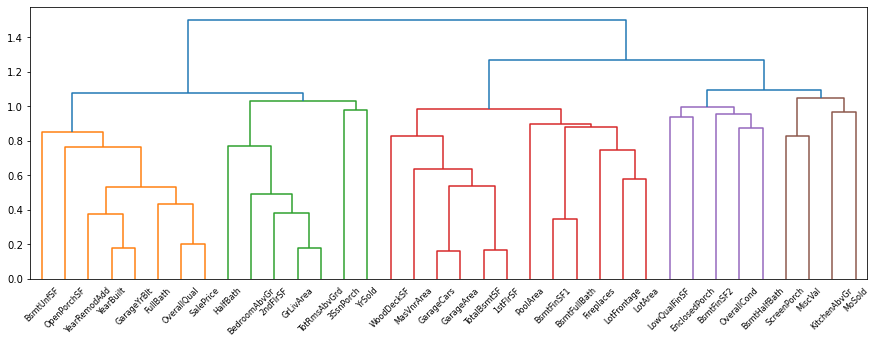

In [108]:
fig = plt.figure(figsize=(15, 5))
link = linkage(tb_sca_housing_num.T, method="complete", metric="cosine")
census_dendogram = dendrogram(link, labels=scaler.feature_names_in_)


<AxesSubplot:>

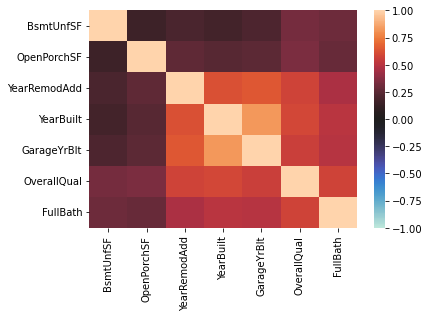

In [109]:
clu_0 = [
    "BsmtUnfSF",
    "OpenPorchSF",
    "YearRemodAdd",
    "YearBuilt",
    "GarageYrBlt",
    "OverallQual",
    "FullBath",
]
sns.heatmap(tb_housing_num[clu_0].corr(), vmin=-1, center=0, vmax=1)


In [110]:
n = 10
var_fit = FeatureAgglomeration(n_clusters=n)
var_fit.fit(tb_sca_housing_num)


FeatureAgglomeration(n_clusters=10)

In [111]:
tb_var_cluster = pd.DataFrame(
    var_fit.transform(tb_sca_housing_num), columns=["CLU_" + str(i) for i in range(n)]
)

# Multi-Dimensional Scaling (MDS)

A *non-linear* version of PCA.

## Using MDS to visualize cluster separation

In [112]:
from sklearn.manifold import MDS

In [119]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/nypd_crime_pct.csv'
tb_nypd = pd.read_csv(url)
tb_nypd.info()

cluster_vars = ['assault_3_&_related_offenses', 'criminal_mischief_&_related_of',
       'dangerous_drugs', 'felony_assault', 'grand_larceny', 'harrassment_2',
       'miscellaneous_penal_law', 'off._agnst_pub_ord_sensblty_&',
       'petit_larceny', 'robbery']

nypd_scaler = StandardScaler()
nypd_scaler.fit(tb_nypd[cluster_vars])

tb_sca_nypd = pd.DataFrame(nypd_scaler.transform(tb_nypd[cluster_vars]), columns = cluster_vars)
tb_sca_nypd.index = tb_nypd['ADDR_PCT_CD']

hc_fit = AgglomerativeClustering(n_clusters = 5, 
                                 affinity='euclidean', 
                                 linkage='ward')
hc_fit.fit(tb_sca_nypd)
tb_sca_nypd['clu_ward'] = [str(x) for x in hc_fit.labels_]
tb_nypd['clu_ward'] = [str(x) for x in hc_fit.labels_]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ADDR_PCT_CD                     77 non-null     float64
 1   assault_3_&_related_offenses    77 non-null     float64
 2   criminal_mischief_&_related_of  77 non-null     float64
 3   dangerous_drugs                 77 non-null     float64
 4   felony_assault                  77 non-null     float64
 5   grand_larceny                   77 non-null     float64
 6   harrassment_2                   77 non-null     float64
 7   miscellaneous_penal_law         77 non-null     float64
 8   off._agnst_pub_ord_sensblty_&   77 non-null     float64
 9   petit_larceny                   77 non-null     float64
 10  robbery                         77 non-null     float64
dtypes: float64(11)
memory usage: 6.7 KB


In [120]:
mds_fit = MDS(n_components=2)
tb_mca_nypd = pd.DataFrame(
    mds_fit.fit_transform(tb_sca_nypd[cluster_vars]),
    columns = ['MC_0', 'MC_1']
)

<AxesSubplot:xlabel='MC_0', ylabel='MC_1'>

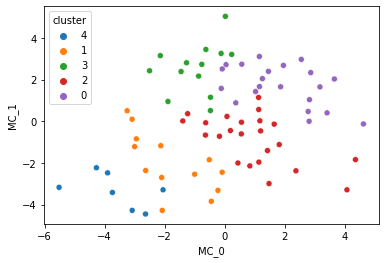

In [121]:
tb_mca_nypd['cluster'] = [str(x) for x in hc_fit.labels_]
sns.scatterplot(data = tb_mca_nypd, x = 'MC_0', y = 'MC_1', hue = 'cluster')

## Using MDS for Clustering

In [218]:
tb_house = pd.read_csv("data/tb_household_electricity.csv", parse_dates = ['date_time'])
tb_house = tb_house.sample(1000, random_state=42).copy()
clu_vars_h = ['sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'voltage', 'global_intensity']
tb_house['hour'] = tb_house['date_time'].dt.hour
tb_house = tb_house.drop('date_time', axis = 1)

scaler = StandardScaler()
scaler.fit(tb_house[clu_vars_h])
tb_sca_cp = pd.DataFrame(
    scaler.transform(tb_house[clu_vars_h]),
    columns = scaler.feature_names_in_
)

In [219]:
mds_fit = MDS(n_components=2)
tb_mca_house = pd.DataFrame(
    mds_fit.fit_transform(tb_sca_cp),
    columns = ['MC_0', 'MC_1']
)
tb_house_mca = pd.concat([tb_house, tb_mca_house], axis = 1)

<AxesSubplot:xlabel='MC_0', ylabel='MC_1'>

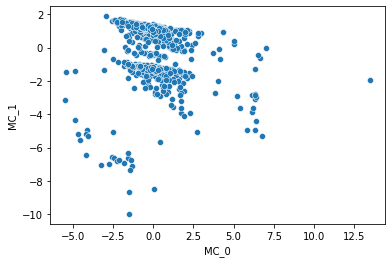

In [220]:
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1')

In [221]:
km_fit = KMeans(n_clusters = 4)
km_fit.fit(tb_mca_house)

KMeans(n_clusters=4)

In [222]:
tb_sca_cp['cluster'] = km_fit.labels_


In [223]:
tb_sca_cp['ID'] = tb_house.index
tb_house_melt = tb_sca_cp.melt(id_vars = ['ID', 'cluster'])

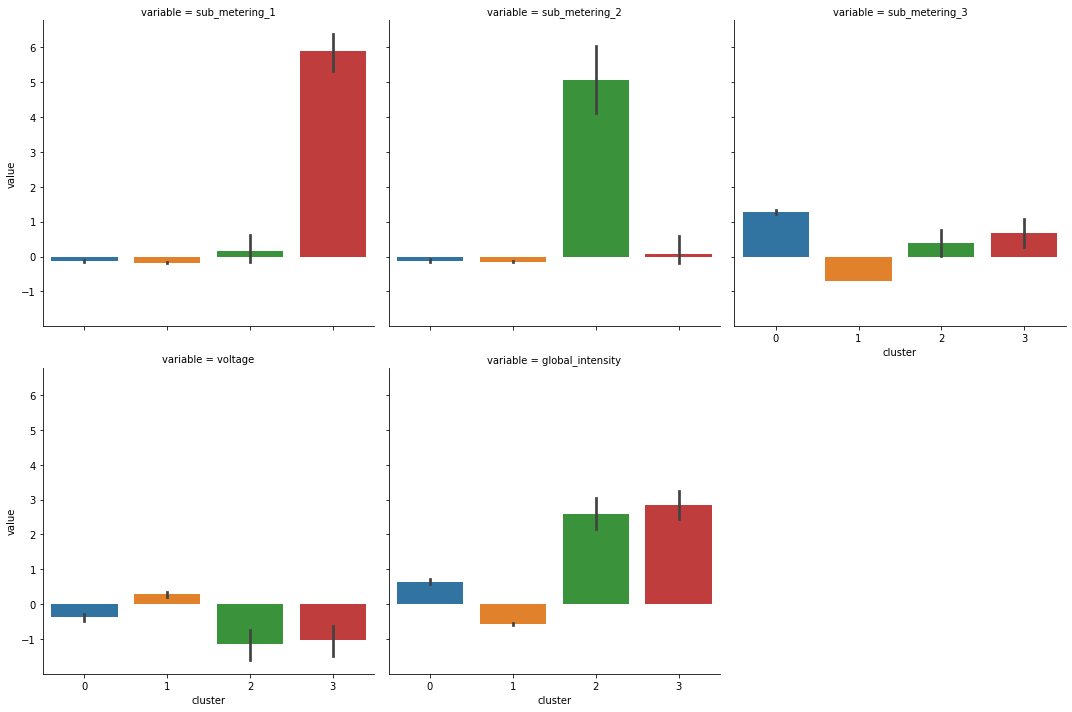

In [224]:
sns.catplot(data = tb_house_melt, x = 'cluster', y = 'value', col= 'variable', kind = 'bar', col_wrap = 3)

<AxesSubplot:xlabel='MC_0', ylabel='MC_1'>

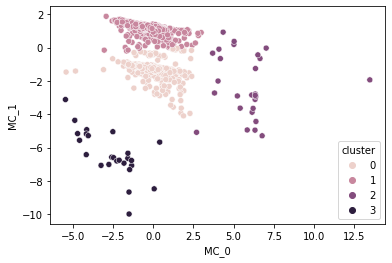

In [225]:
tb_mca_house['cluster'] = km_fit.labels_
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', hue = 'cluster')

In [231]:
neighbors = 20
nbrs = NearestNeighbors(n_neighbors=neighbors)
nbrs.fit(tb_mca_house)

distances, indices = nbrs.kneighbors(tb_mca_house)
distance_desc = sorted(distances[:,-1], reverse=True)

kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc,
                      S=2,
                      curve="convex",
                      direction="decreasing")
                      
print(f"Optimal Knee found at eps = {np.round(kneedle.knee_y, 2)}\nwith min_samples = {neighbors}")

Optimal Knee found at eps = 1.23
with min_samples = 20


In [232]:
db_fit = DBSCAN(eps = 1.23, min_samples = 10)
db_fit.fit(tb_mca_house)
tb_mca_house['db_cluster'] = db_fit.labels_

<AxesSubplot:xlabel='MC_0', ylabel='MC_1'>

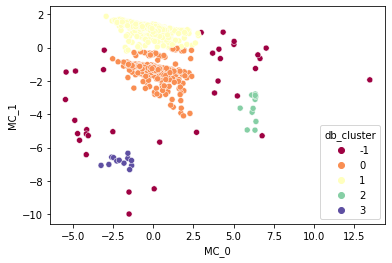

In [233]:
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', hue = 'db_cluster', palette='Spectral')

In [234]:
tb_sca_cp['db_cluster'] = db_fit.labels_
tb_house_melt = tb_sca_cp.melt(id_vars = ['ID', 'cluster', 'db_cluster'])

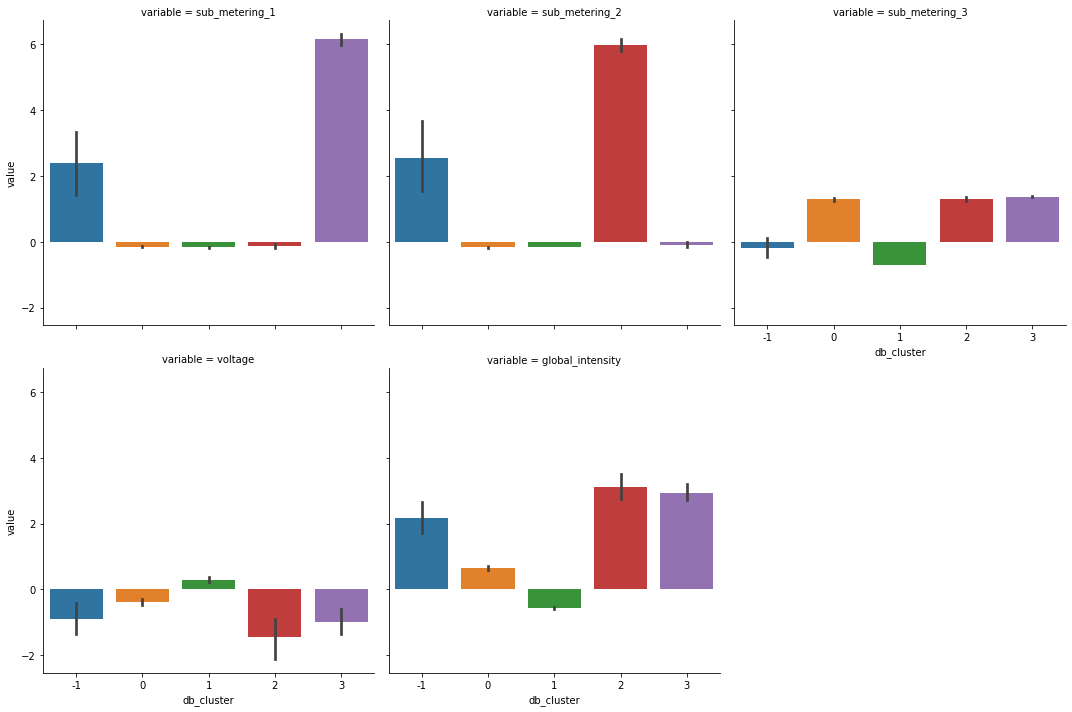

In [235]:
sns.catplot(data = tb_house_melt, x = 'db_cluster', y = 'value', col= 'variable', kind = 'bar', col_wrap = 3)

# Using t-SNE to Visualize Data

In [197]:
from sklearn.manifold import TSNE

In [271]:
tsne_fit = TSNE(init = 'pca', learning_rate = 'auto', perplexity=150)
tb_tsne_housing = pd.DataFrame(
    tsne_fit.fit_transform(tb_sca_housing_num),
    columns = ['TS_1', 'TS_2']
)
tb_tsne_housing['SalePrice'] = tb_housing_num['SalePrice']

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:xlabel='TS_1', ylabel='TS_2'>

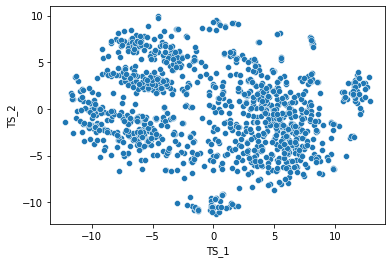

In [276]:
sns.scatterplot(data = tb_tsne_housing, x = 'TS_1', y = 'TS_2', palette='Spectral')